In [ ]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

In [ ]:
# Variable declarations
nx = 40
ny = 40
nt = 499
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
dt = 0.001
rho = 1.0
nu = 0.1

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X,Y = np.meshgrid(x,y)

u_initial = np.ones((ny, nx))
v_initial = np.ones((ny, nx))
p_initial = np.ones((ny, nx))

# Initial conditions
domain = (slice(int(.5 / dy), int(1 / dy + 1)), slice(int(.5 / dx), int(1 / dx + 1)))
u_initial[domain] = 5
v_initial[domain] = 5

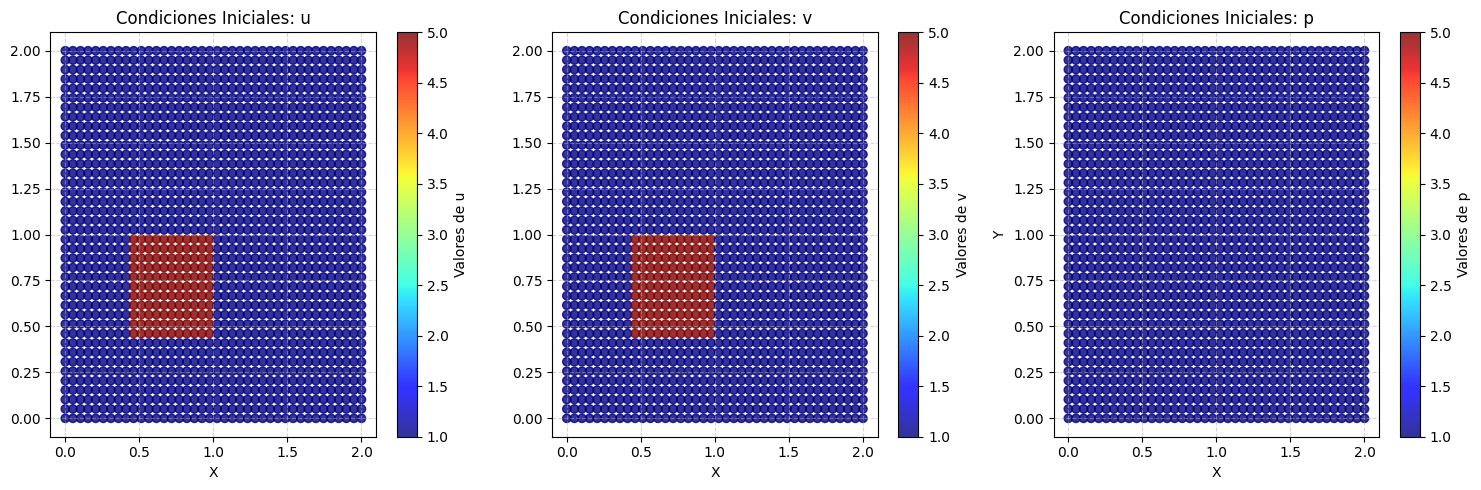

In [ ]:
# Configurar la figura con 3 subgráficos
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Gráfica de u
s0 = axes[0].scatter(X, Y, c=u_initial, cmap='jet', alpha=0.8,vmin=1,vmax=5)
axes[0].set_title("Condiciones Iniciales: u")
axes[0].set_xlabel("X")
axes[0].grid(True, linestyle='--', alpha=0.5)
fig.colorbar(s0, ax=axes[0], label="Valores de u")

# Gráfica de v
s1 = axes[1].scatter(X, Y, c=v_initial, cmap='jet', alpha=0.8,vmin=1,vmax=5)
axes[1].set_title("Condiciones Iniciales: v")
axes[1].set_xlabel("X")
axes[1].grid(True, linestyle='--', alpha=0.5)
fig.colorbar(s1, ax=axes[1], label="Valores de v")

s2 = axes[2].scatter(X, Y, c=p_initial, cmap='jet', alpha=0.8,vmin=1,vmax=5)
axes[2].set_title("Condiciones Iniciales: p")
axes[2].set_xlabel("X")
axes[2].set_ylabel("Y")
axes[2].grid(True, linestyle='--', alpha=0.5)
fig.colorbar(s2, ax=axes[2], label="Valores de p")

# Guardar y mostrar la figura
plt.tight_layout()
plt.savefig('cond_iniciales_p_u_v.jpg')
plt.show()

In [ ]:
def pressure_poisson(p, dx, dy, tol=1e-4, max_iter=500):
    pn = np.empty_like(p)
    for _ in range(max_iter):
        pn[:] = p
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, :-2]) * dy**2 +
                           (pn[2:, 1:-1] + pn[:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)))

        # Boundary conditions
        p[:, -1] = p[:, -2]
        p[0, :] = p[1, :]
        p[:, 0] = p[:, 1]
        p[-1, :] = 0
    return p

In [ ]:
def navier_stokes(nt, u, v, p, dx, dy, dt, rho, nu):
    u_all = np.zeros((nt, ny, nx))
    v_all = np.zeros((nt, ny, nx))
    p_all = np.zeros((nt, ny, nx))

    un = np.empty_like(u)
    vn = np.empty_like(v)

    for t in range(nt):
        un[:] = u
        vn[:] = v
        p = pressure_poisson(p, dx, dy)

        # Update velocity fields
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] - dt / dx * un[1:-1, 1:-1] * (un[1:-1, 1:-1] - un[1:-1, :-2]) -
                          dt / dy * vn[1:-1, 1:-1] * (un[1:-1, 1:-1] - un[:-2, 1:-1]) -
                          dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, :-2]) +
                          nu * (dt / dx**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, :-2]) +
                               dt / dy**2 * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[:-2, 1:-1])))

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] - dt / dx * un[1:-1, 1:-1] * (vn[1:-1, 1:-1] - vn[1:-1, :-2]) -
                          dt / dy * vn[1:-1, 1:-1] * (vn[1:-1, 1:-1] - vn[:-2, 1:-1]) -
                          dt / (2 * rho * dy) * (p[2:, 1:-1] - p[:-2, 1:-1]) +
                          nu * (dt / dx**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, :-2]) +
                               dt / dy**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[:-2, 1:-1])))

        u_all[t] = u
        v_all[t] = v
        p_all[t] = p

    return u_all, v_all, p_all

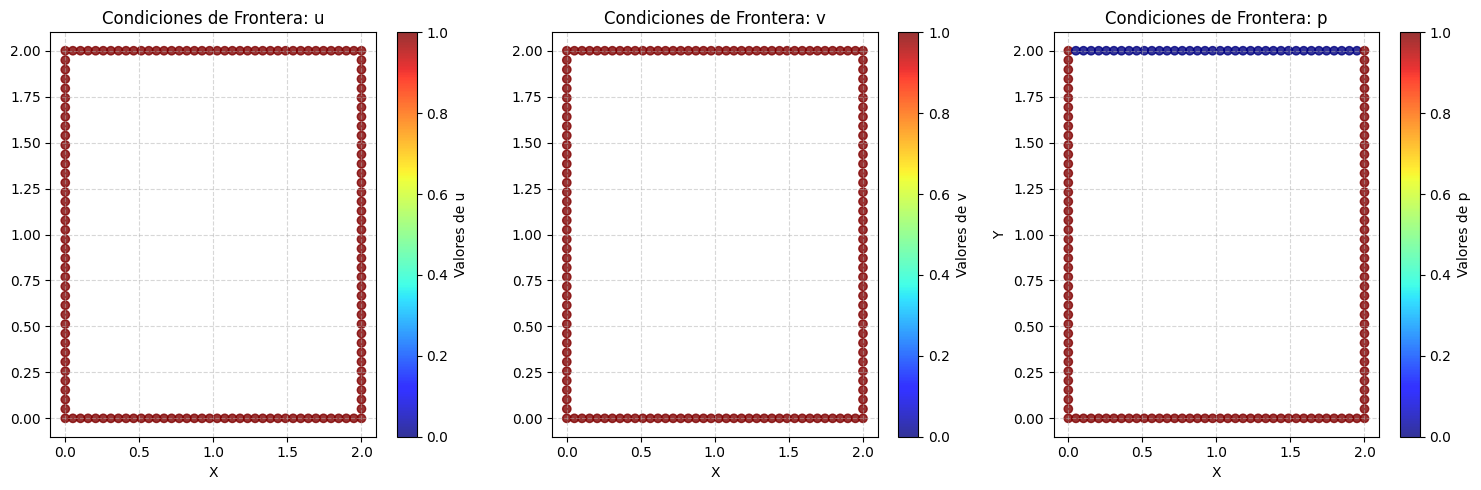

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definir la malla
nx, ny = 40, 40  # Número de puntos en cada dirección
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

# Función para obtener los puntos de frontera y sus valores
def get_boundary_points(X, Y, condition_type="p"):
    border_x, border_y, border_values = [], [], []

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if condition_type == "p":
                if j == 0 or j == X.shape[1] - 1:  # dp/dx = 0 en x = 0 y x = 2
                    border_x.append(X[i, j])
                    border_y.append(Y[i, j])
                    border_values.append(1)
                elif i == 0:  # dp/dy = 0 en y = 0
                    border_x.append(X[i, j])
                    border_y.append(Y[i, j])
                    border_values.append(1)
                elif i == X.shape[0] - 1:  # p = 0 en y = 2
                    border_x.append(X[i, j])
                    border_y.append(Y[i, j])
                    border_values.append(0)

            elif condition_type in ["u", "v"]:
                if i == 0 or i == X.shape[0] - 1 or j == 0 or j == X.shape[1] - 1:
                    border_x.append(X[i, j])
                    border_y.append(Y[i, j])
                    border_values.append(1)  # u, v = 1 en los bordes

    return border_x, border_y, border_values

# Obtener los puntos para cada variable
px, py, p_values = get_boundary_points(X, Y, "p")
ux, uy, u_values = get_boundary_points(X, Y, "u")
vx, vy, v_values = get_boundary_points(X, Y, "v")

# Configurar la figura con 3 subgráficos
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Gráfica de u
sc0 = axes[0].scatter(ux, uy, c=u_values, cmap='jet', alpha=0.8,vmin=0,vmax=1)
axes[0].set_title("Condiciones de Frontera: u")
axes[0].set_xlabel("X")
axes[0].grid(True, linestyle='--', alpha=0.5)
fig.colorbar(sc0, ax=axes[0], label="Valores de u")

# Gráfica de v
sc1 = axes[1].scatter(vx, vy, c=v_values, cmap='jet', alpha=0.8,vmin=0,vmax=1)
axes[1].set_title("Condiciones de Frontera: v")
axes[1].set_xlabel("X")
axes[1].grid(True, linestyle='--', alpha=0.5)
fig.colorbar(sc1, ax=axes[1], label="Valores de v")

sc2 = axes[2].scatter(px, py, c=p_values, cmap='jet', alpha=0.8,vmin=0,vmax=1)
axes[2].set_title("Condiciones de Frontera: p")
axes[2].set_xlabel("X")
axes[2].set_ylabel("Y")
axes[2].grid(True, linestyle='--', alpha=0.5)
fig.colorbar(sc2, ax=axes[2], label="Valores de p")

# Guardar y mostrar la figura
plt.tight_layout()
plt.savefig('cond_frontera_p_u_v.jpg')
plt.show()

In [ ]:
u, v, p = navier_stokes(nt, u_initial, v_initial, p_initial, dx, dy, dt, rho, nu)

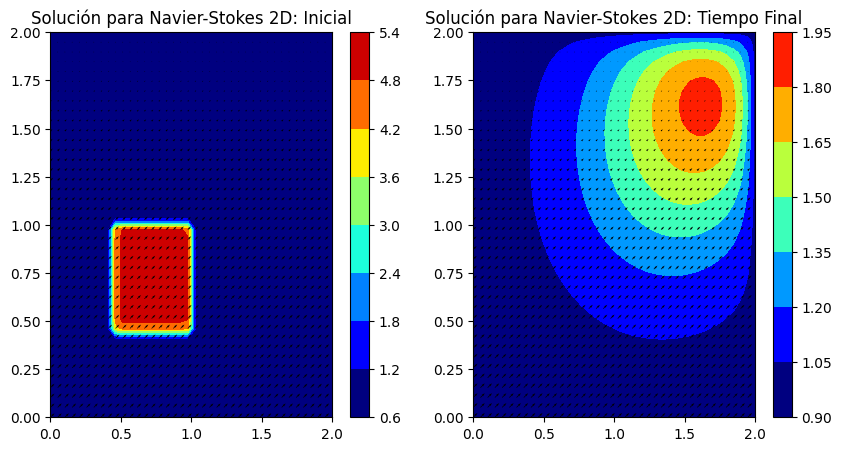

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.subplot(1,2,1)
plt.contourf(X, Y, u[0], cmap='jet',vmin=1,vmax=5.4)
plt.contourf(X,Y,v[0],cmap='jet',vmin=1,vmax=5.4)
plt.colorbar()
plt.quiver(X, Y, p[0], p[0], cmap='jet')
plt.title("Solución para Navier-Stokes 2D: Inicial")
plt.savefig('Solución_ns_ti.jpg')

plt.subplot(1,2,2)
plt.contourf(X, Y, u[498], cmap='jet',vmin=1,vmax=2)
plt.contourf(X,Y,v[498],cmap='jet',vmin=1,vmax=2)
plt.colorbar()
plt.quiver(X, Y, p[498], p[498], cmap='jet')
plt.title("Solución para Navier-Stokes 2D: Tiempo Final")

plt.savefig('Sol_ns_mdf.jpg')
plt.show()

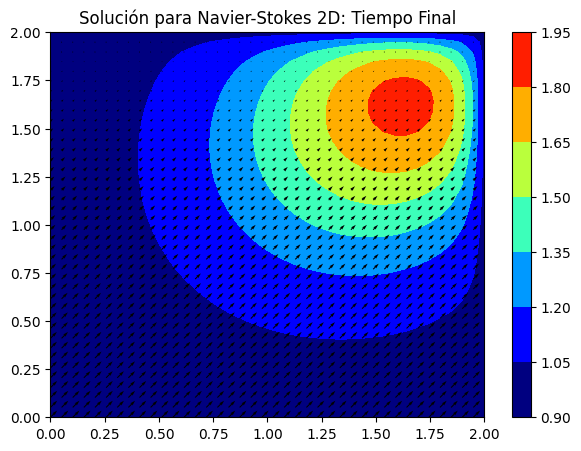

In [ ]:
plt.figure(figsize=(7, 5), dpi=100)
plt.contourf(X, Y, u[498], cmap='jet',vmin=1,vmax=2)
plt.contourf(X,Y,v[498],cmap='jet',vmin=1,vmax=2)
plt.colorbar()
plt.quiver(X, Y, p[498], p[498], cmap='jet')
plt.title("Solución para Navier-Stokes 2D: Tiempo Final")
plt.savefig('Solución_ns_mdf.jpg')
plt.show()

In [ ]:
# First plot (Initial Conditions)
im0 = axes[0].contourf(X, Y, u[0], cmap='jet', vmin=1, vmax=5.4)
axes[0].set_title("Initial Conditions")
fig.colorbar(im0, ax=axes[0])

# Second plot (Final time step)
im1 = axes[1].contourf(X, Y, u[498], cmap='jet', vmin=1, vmax=2)
axes[1].set_title("Final Time Step")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

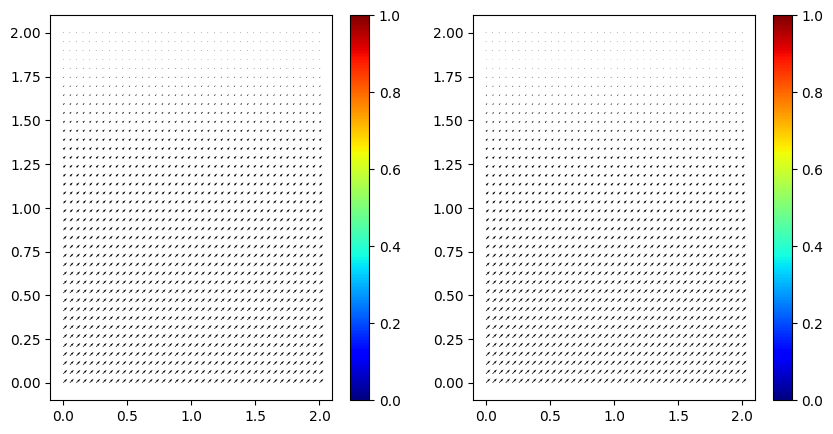

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.subplot(1,2,1)
plt.quiver(X, Y, p[0],p[0], cmap='jet')
plt.colorbar()
plt.subplot(1,2,2)
plt.quiver(X,Y,p[498],p[498],cmap='jet')
plt.colorbar()

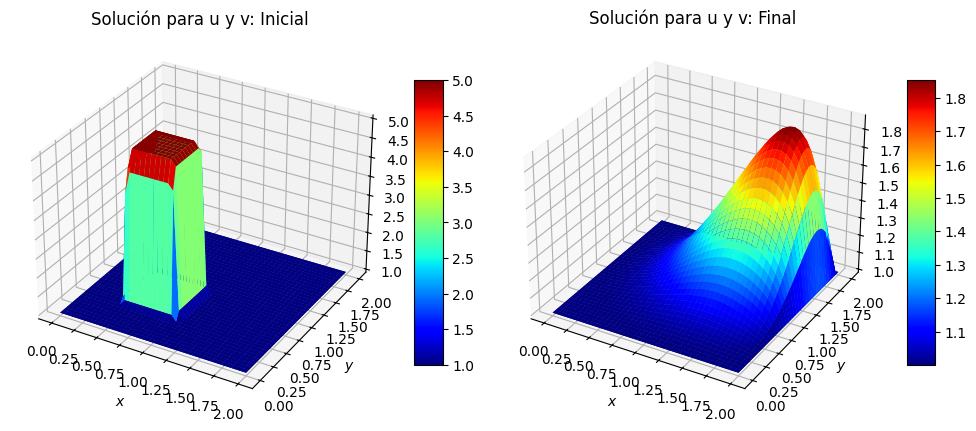

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6), dpi=100)

# Subplot for n=0 (Inicial)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
X, Y = np.meshgrid(x, y)
surf1_u = ax1.plot_surface(X, Y, u[0], cmap='jet', rstride=1, cstride=1)
surf1_v = ax1.plot_surface(X, Y, v[0], cmap='jet', rstride=1, cstride=1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title('Solución para u y v: Inicial')
fig.colorbar(surf1_u, ax=ax1, shrink=0.5, aspect=10)  # Agregamos la barra de color

# Subplot for n=498 (Final)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2_u = ax2.plot_surface(X, Y, u[498], cmap='jet', rstride=1, cstride=1)
surf2_v = ax2.plot_surface(X, Y, v[498], cmap='jet', rstride=1, cstride=1)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title('Solución para u y v: Final')
fig.colorbar(surf2_u, ax=ax2, shrink=0.5, aspect=10)  # Agregamos la barra de color

plt.tight_layout()  # Ajuste para evitar solapamiento
plt.savefig('solucion_u_v_t0f.jpg')
plt.show()

In [ ]:
pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Dimensiones de la malla
nx, ny = 40,40
X, Y = np.meshgrid(np.linspace(0, 2, nx), np.linspace(0, 2, ny))
tiempos_muestreados = np.linspace(0, 498, 6, dtype=int)  # Tiempos a visualizar

# Crear figura interactiva
fig = go.Figure()

# Agregar planos de evolución temporal de la temperatura
for t_index in range(6):  # 10 pasos de tiempo
    fig.add_trace(
        go.Surface(
            x=X,
            y=np.full_like(X, t_index),
            z=Y,  # Altura = tiempo
            surfacecolor=u[t_index],  # Valores de temperatura
            #colorscale=[[0, 'blue'], [0.5, 'white'], [1, 'red']],
            opacity=0.5,
            showscale=False
        )
    )

# Agregar scatter en tiempos clave
for t_index in tiempos_muestreados:
    fig.add_trace(go.Scatter3d(
        x=X.flatten(), y=np.full_like(X.flatten(), t_index), z=Y.flatten(),
        mode='markers',
        marker=dict(size=3, color=u[t_index].flatten()), #colorscale=[[0, 'blue'], [0.5, 'white'], [1, 'red']]),
        name=f"t = {t_index/1000}"
    ))

# Configurar diseño del gráfico
fig.update_layout(
    title="Evolución de u y v en 3D con Scatter",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Tiempo",
        zaxis_title="Y",
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        zaxis=dict(showgrid=True),
        aspectratio=dict(x=1, y=2, z=1)
    ),
    scene_camera=dict(
        eye=dict(x=2, y=-1.3, z=1)
      )  # Ajusta el ángulo de visión
)

# Mostrar la figura
fig.show()

fig.write_image("evolucion_ns_3D.jpg",scale=2)   # JPG